# Bibliotecas

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import csv
import matplotlib.gridspec as gridspec

from sklearn import svm
from sklearn import tree

#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier

from sklearn import ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

from sklearn import preprocessing

from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

np.random.seed(12345) #Deseja fixar a semente geradora de números aleatórios?

# Paletas

In [5]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
yell = np.array([220/256, 210/256, 90/256, 1])
blu = np.array([120/256, 170/256, 256/256, 1])
gre = np.array([1/256, 170/256, 1/256, 1])
red = np.array([255/256, 1/256, 1/256, 1])
#newcolors[0:127, :] = blu
#newcolors[128:255, :] = yell
newcolors[0:63, :] = blu
newcolors[64:127, :] = yell
newcolors[128:195, :] = gre
newcolors[196:255, :] = red
newcmp = ListedColormap(newcolors)

# Funções

In [6]:
#Função de leitura dos dados------------------------------------
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack( (data , np.asarray(row).astype(np.float) ) )
            except:
                data = np.asarray(row).astype(np.float)
    f.close()
    y = data[:,0]
    x = data[:,1:]
    return y,x

# Leitura dos dados e ajustes

In [25]:
#Dados de treinamento
path = 'dadosR3.txt'
path_out = '/home/rogerio/GIT/rp/blucher/figs/CapComb/bagging_dadosSim.pdf'

caso = 0    #0-bagging, 1-regraSoma, 2-maioria voto, 3-AdaBoost, 4-Random Forest, 5-stacking


#Leitura dos dados
y,x_ = read_class_data(path)

x = preprocessing.normalize(x_, norm='max', axis=0)
#-------------------------------------------------------------------------------------


#Gerar conjunto de treino e avaliação a partir de uma única fonte
percentAvalia = 0.33

#A ordenação dos valores aleatórios segundo seu índice/argumento
#O resultado é uma nova ordem aleatória (mais conveniente para este caso)
posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0] ))

#Subconjunto de avaliação
yI = y[ posAleatorias[0: np.int64(np.ceil(x.shape[0]*percentAvalia)) ] ]
xI = x[ posAleatorias[0: np.int64(np.ceil(x.shape[0]*percentAvalia)) ] , :]

#Subconjunto de treino
yD = y[ posAleatorias[np.int64(np.floor(x.shape[0]*percentAvalia)):-1] ]
xD = x[ posAleatorias[np.int64(np.floor(x.shape[0]*percentAvalia)):-1] , :]

# Processamentos

In [23]:
#BAGGING-------------------------------------------------------------------------------------
if caso == 0:

    #Instanciação
    combClass = ensemble.BaggingClassifier(base_estimator= svm.SVC(C=100, kernel='linear'), n_estimators=10, random_state=0)
    #combClass = svm.SVC(C=100, kernel='linear')

    #Treinamento
    combClass.fit(xD,yD)

    #Predição efetuada por cada uma das redes
    yEst = combClass.predict(xI)

    #Concordâncias...
    avalia = np.count_nonzero(yEst == yI) / yI.shape[0]
    print('Acurácia: ', avalia)


#SOFT VOTING (Regra da Soma)--------------------------------------------------------------------------------
if caso == 1:

    g1 = tree.DecisionTreeClassifier(max_depth=4)
    g2 = tree.DecisionTreeClassifier(max_depth=8)
    g3 = svm.SVC(kernel='linear', C=100, probability=True)
    g4 = svm.SVC(kernel='rbf', C=100, gamma=0.5, probability=True)

    estimadores = [('dt1', g1),('dt2', g2),('svc1', g3),('svc2', g4)]
    combClass = VotingClassifier(estimators=estimadores,voting='soft', weights=[1, 1, 1, 1])

    combClass.fit(xD, yD)

    #Predição efetuada por cada uma das redes
    yEst = combClass.predict(xI)

    #Concordâncias...
    avalia = np.count_nonzero(yEst == yI) / yI.shape[0]
    print('Acurácia: ', avalia)


#HARD VOTING (Maioria Votos)--------------------------------------------------------------------------------
if caso == 2:

    g1 = tree.DecisionTreeClassifier(min_samples_split=2)
    g2 = tree.DecisionTreeClassifier(min_samples_split=10)
    g3 = svm.SVC(kernel='linear', C=100, probability=True)
    g4 = svm.SVC(kernel='rbf', C=100, gamma=0.5, probability=True)

    combClass = VotingClassifier(estimators=[('dt1', g1),('dt2', g2),('svc1', g3),('svc2', g4)],
                                 voting='hard')

    combClass.fit(xD, yD)

    #Predição efetuada por cada uma das redes
    yEst = combClass.predict(xI)

    #Concordâncias...
    avalia = np.count_nonzero(yEst == yI) / yI.shape[0]
    print('Acurácia: ', avalia)


#ADABOOST-SAMME------------------------------------------------------------------------------
if caso == 3:
    combClass = AdaBoostClassifier(tree.DecisionTreeClassifier(min_samples_split=10),n_estimators=10)
    combClass.fit(xD, yD)

    #Predição efetuada por cada uma das redes
    yEst = combClass.predict(xI)

    #Concordâncias...
    avalia = np.count_nonzero(yEst == yI) / yI.shape[0]
    print('Acurácia: ', avalia)


#RANDOM FOREST------------------------------------------------------------------------------
if caso == 4:    
    combClass = RandomForestClassifier(n_estimators=40, criterion='entropy', 
                                       min_samples_split=2, min_impurity_decrease=10**(-5),random_state=1)
    
    combClass.fit(xD, yD)

    #Predição efetuada por cada uma das redes
    yEst = combClass.predict(xI)

    #Concordâncias...
    avalia = np.count_nonzero(yEst == yI) / yI.shape[0]
    print('Acurácia: ', avalia)


#STACKING------------------------------------------------------------------------------
if caso == 5:    
    g1 = tree.DecisionTreeClassifier(max_depth=4)
    g2 = tree.DecisionTreeClassifier(max_depth=8)
    g3 = svm.SVC(kernel='linear', C=100, probability=True)
    g4 = svm.SVC(kernel='rbf', C=100, gamma=0.5, probability=True)

    estimadores = [('dt1', g1),('dt2', g2),('svc1', g3),('svc2', g4)]
    
    combClass = StackingClassifier(estimators=estimadores, final_estimator=svm.SVC(kernel='rbf', C=100, gamma=0.5) )
    
    combClass.fit(xD, yD)

    #Predição efetuada por cada uma das redes
    yEst = combClass.predict(xI)

    #Concordâncias...
    avalia = np.count_nonzero(yEst == yI) / yI.shape[0]
    print('Acurácia: ', avalia)

Acurácia:  0.8409090909090909


# Visualização

<ipython-input-31-e8b01845f5c1>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(spec[0, 0])


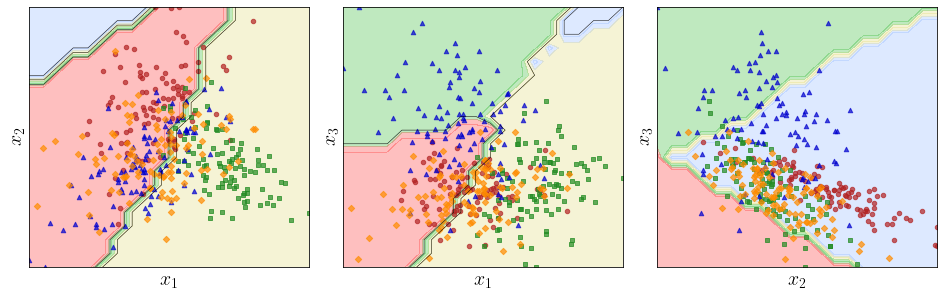

In [31]:
N = 20

#-------------------------------------------------------------
#Class Espaço 3d
#minX = np.min(x[:,0])-1; maxX = np.max(x[:,0])+1
#minY = np.min(x[:,1])-1; maxY = np.max(x[:,1])+1
#minZ = np.min(x[:,2])-1; maxZ= np.max(x[:,2])+1
minX = np.min(x[:,0]); maxX = np.max(x[:,0])
minY = np.min(x[:,1]); maxY = np.max(x[:,1])
minZ = np.min(x[:,2]); maxZ= np.max(x[:,2])

X1 = np.linspace(minX, maxX, N)
X2 = np.linspace(minY, maxY, N)
X3 = np.linspace(minZ, maxZ, N)

#Modelo....
CLA = np.zeros((N,N,N))
for i in range(0,N):
    for j in range(0,N):
        for k in range(0,N):
            CLA[i,j,k] = combClass.predict( [[ X1[i], X2[j], X3[k] ]] )#[0]

    
FS = (13,4) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

marr = ['o','s','^','D']
coll = ['firebrick','forestgreen','mediumblue','darkorange']; vecCol = ['']
for i in yD: vecCol.append(coll[ int(i-1) ])
vecCol.pop(0)


ax = fig.add_subplot(spec[0, 0])
at1, at2 = np.meshgrid(X1, X2)
tempCLA = CLA[:,:,0].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
ax.contour(at1, at2, tempCLA.T, [0,1,2,3,4,5] , colors='k',linewidths=0.5)
#ax.scatter(xD[:, 0], xD[:, 1], marker='o', c=vecCol, s=25)#, edgecolor='k')
for i in range(0,4):
    ax.scatter(x=x[np.where(y == i+1),0], y=x[np.where(y == i+1),1], marker=marr[i], c=coll[i], s=20, alpha=0.7)
ax.set_xlabel('$x_1$', fontsize=20); ax.set_ylabel('$x_2$', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_aspect('equal')


ax = fig.add_subplot(spec[0, 1])
at1, at2 = np.meshgrid(X1, X3)
tempCLA = CLA[:,0,:].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
ax.contour(at1, at2, tempCLA.T, [0,1,2,3,4,5] , colors='k',linewidths=0.5)
#plt.scatter(xD[:, 0], xD[:, 2], marker='o', c=vecCol, s=25)#, edgecolor='k')
for i in range(0,4):
    ax.scatter(x=x[np.where(y == i+1),0], y=x[np.where(y == i+1),2], marker=marr[i], c=coll[i], s=20, alpha=0.7)
ax.set_xlabel('$x_1$', fontsize=20); ax.set_ylabel('$x_3$', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_aspect('equal')


ax = fig.add_subplot(spec[0, 2])
at1, at2 = np.meshgrid(X2, X3)
tempCLA = CLA[0,:,:].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
#plt.scatter(xD[:, 1], xD[:, 2], marker='o', c=vecCol, s=25)#, edgecolor='k')
for i in range(0,4):
    ax.scatter(x=x[np.where(y == i+1),1], y=x[np.where(y == i+1),2], marker=marr[i], c=coll[i], s=20, alpha=0.7)
ax.set_xlabel('$x_2$', fontsize=20); ax.set_ylabel('$x_3$', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_aspect('equal')

plt.savefig(path_out, dpi=300, bbox_inches='tight', format='pdf')

In [ ]:
#ax = plt.subplot(234)
ax = fig.add_subplot(spec[1, 0])
at1, at2 = np.meshgrid(X2, X3)
tempCLA = CLA[0,:,:,0].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
plt.scatter(xD[:, 1], xD[:, 2], marker='o', c=vecCol, s=25)#, edgecolor='k')
ax.set_xlabel('$x_2$', fontsize=20); ax.set_ylabel('$x_3$', fontsize=20)

#ax = plt.subplot(235)
ax = fig.add_subplot(spec[1, 1])
at1, at2 = np.meshgrid(X2, X4)
tempCLA = CLA[0,:,0,:].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
plt.scatter(xD[:, 1], xD[:, 3], marker='o', c=vecCol, s=25)#, edgecolor='k')
ax.set_xlabel('$x_2$', fontsize=20); ax.set_ylabel('$x_4$', fontsize=20)

#ax = plt.subplot(236)
ax = fig.add_subplot(spec[1, 2])
at1, at2 = np.meshgrid(X3, X4)
tempCLA = CLA[0,0,:,:].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
plt.scatter(xD[:, 2], xD[:, 3], marker='o', c=vecCol, s=25)#, edgecolor='k')
ax.set_xlabel('$x_3$', fontsize=20); ax.set_ylabel('$x_4$', fontsize=20)

In [ ]:







#-------------------------------------------------------------------------------------




#Stacking...
#def stacking_svm_cart(x,y,n,)




#-------------------------------------------------------------------------------------




#-------------------------------------------------------------------------------------






#-------------------------------------------------------------
#Class Espaço 4d
minX = np.min(x[:,0])-1; maxX = np.max(x[:,0])+1
minY = np.min(x[:,1])-1; maxY = np.max(x[:,1])+1
minZ = np.min(x[:,2])-1; maxZ= np.max(x[:,2])+1
minW = np.min(x[:,3])-1; maxW = np.max(x[:,3])+1

X1 = np.linspace(minX, maxX, N)
X2 = np.linspace(minY, maxY, N)
X3 = np.linspace(minZ, maxZ, N)
X4 = np.linspace(minW, maxW, N)

#Modelo....
CLA = np.zeros((N,N,N,N))
for i in range(0,N):
    for j in range(0,N):
        for k in range(0,N):
            for l in range(0,N):
                #padrao = np.array( [X1[i,j], X2[i,j]] )
                CLA[i,j,k,l] = combClass.predict( [[ X1[i], X2[j], X3[k], X4[l] ]] )[0]

    
FS = (13,8) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

ax = fig.add_subplot(spec[0, 0])

coll = ['red','blue','green','orange']; vecCol = ['']
for i in yD: vecCol.append(coll[ int(i-1) ])
vecCol.pop(0)

#ax = plt.subplot(231)
ax = fig.add_subplot(spec[0, 0])
at1, at2 = np.meshgrid(X1, X2)
tempCLA = CLA[:,:,0,0].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
ax.scatter(xD[:, 0], xD[:, 1], marker='o', c=vecCol, s=25)#, edgecolor='k')
ax.set_xlabel('$x_1$', fontsize=20); ax.set_ylabel('$x_2$', fontsize=20)

#ax = plt.subplot(232)
ax = fig.add_subplot(spec[0, 1])
at1, at2 = np.meshgrid(X1, X3)
tempCLA = CLA[:,0,:,0].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
plt.scatter(xD[:, 0], xD[:, 2], marker='o', c=vecCol, s=25)#, edgecolor='k')
ax.set_xlabel('$x_1$', fontsize=20); ax.set_ylabel('$x_3$', fontsize=20)

#ax = plt.subplot(233)
ax = fig.add_subplot(spec[0, 2])
at1, at2 = np.meshgrid(X1, X4)
tempCLA = CLA[:,0,0,:].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
plt.scatter(xD[:, 0], xD[:, 3], marker='o', c=vecCol, s=25)#, edgecolor='k')
ax.set_xlabel('$x_1$', fontsize=20); ax.set_ylabel('$x_4$', fontsize=20)

#ax = plt.subplot(234)
ax = fig.add_subplot(spec[1, 0])
at1, at2 = np.meshgrid(X2, X3)
tempCLA = CLA[0,:,:,0].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
plt.scatter(xD[:, 1], xD[:, 2], marker='o', c=vecCol, s=25)#, edgecolor='k')
ax.set_xlabel('$x_2$', fontsize=20); ax.set_ylabel('$x_3$', fontsize=20)

#ax = plt.subplot(235)
ax = fig.add_subplot(spec[1, 1])
at1, at2 = np.meshgrid(X2, X4)
tempCLA = CLA[0,:,0,:].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
plt.scatter(xD[:, 1], xD[:, 3], marker='o', c=vecCol, s=25)#, edgecolor='k')
ax.set_xlabel('$x_2$', fontsize=20); ax.set_ylabel('$x_4$', fontsize=20)

#ax = plt.subplot(236)
ax = fig.add_subplot(spec[1, 2])
at1, at2 = np.meshgrid(X3, X4)
tempCLA = CLA[0,0,:,:].reshape((N,N))
ax.contourf(at1, at2, tempCLA.T, cmap=newcmp,alpha=0.25)
plt.scatter(xD[:, 2], xD[:, 3], marker='o', c=vecCol, s=25)#, edgecolor='k')
ax.set_xlabel('$x_3$', fontsize=20); ax.set_ylabel('$x_4$', fontsize=20)

plt.savefig(path_save_fig,dpi=300)

plt.show()
print(1)